# Human Activity Recognition using the WISDM dataset


### Dataset Context

This dataset contains data collected through controlled, laboratory conditions.

**Experiments**: Twenty-nine  volunteer  subjects  carried  a  smart  phone  while  performing  a  specific  set  of  activities. These subjects carried the Android phone in their front pants  leg  pocket  and  were  asked  to  walk,  jog,  ascend  stairs, descend stairs, sit, and stand for specific periods of time. 

Raw Time Series Data:
- Number of examples: 1,098,207
- Number of attributes: 6
- Missing attribute values: None
- Class Distribution:
  - Walking: 424,400 (38.6%)
  - Jogging: 342,177 (31.2%)
  - Upstairs: 122,869 (11.2%)
  - Downstairs: 100,427 (9.1%)
  - Sitting: 59,939 (5.5%)
  - Standing: 48,395 (4.4%)

Transformed Examples:
- Number of transformed examples: 5,424
- Number of transformed attributes: 46
- Missing attribute values: None
- Class Distribution:
  - Walking: 2,082 (38.4%)
  - Jogging: 1,626 (30.0%)
  - Upstairs: 633 (11.7%)
  - Downstairs: 529 (9.8%)
  - Sitting: 307 (5.7%)
  - Standing: 247 (4.6%)

**Here, for the experiments, there will be use of the raw data file: `WISDM_ar_v1.1_raw.txt`**

Download Link: https://github.com/tzamalisp/dev_tasks/blob/master/datasets/WISDM_ar_latest.tar.gz

In [1]:
import os
os.chdir(os.path.join(os.getcwd(), os.pardir))

In [2]:
import numpy as np
import pandas as pd

# plot figures in a pretty way
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

# internal tasks
from tasks.project_configuration.configuration import config_data, save_paths

In [3]:
# config data (dictionary)
config = config_data()

In [4]:
# saving paths
saving_paths = save_paths(config, "Notebooks/NN07")

In [5]:
dataset_path = os.path.join(config["path_app_saving"], "datasets", "WISDM_ar_v1.1", "WISDM_ar_v1.1_raw.txt")

In [6]:
# reading raw data file
columns = ["user", "activity", "timestamp", "x-axis", "y-axis", "z-axis"]
har_df = pd.read_csv(dataset_path, header=None, names=columns)

In [7]:
har_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x-axis     1098204 non-null  float64
 4   y-axis     1098204 non-null  float64
 5   z-axis     1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 50.3+ MB


In [8]:
# removing null values
har_df = har_df.dropna()
har_df.shape

(1098203, 6)

In [9]:
har_df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


In [10]:
har_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 58.7+ MB


In [11]:
# transforming the z-axis to float
har_df["z-axis"] = har_df["z-axis"].str.replace(";", "")
har_df["z-axis"] = har_df["z-axis"].apply(lambda x:float(x))

In [12]:
# drop the rows where timestamp is 0
df = har_df[har_df["timestamp"] != 0]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085360 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1085360 non-null  int64  
 1   activity   1085360 non-null  object 
 2   timestamp  1085360 non-null  int64  
 3   x-axis     1085360 non-null  float64
 4   y-axis     1085360 non-null  float64
 5   z-axis     1085360 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.0+ MB


In [14]:
# arrange data in ascending order of the user and timestamp
df = df.sort_values(by = ["user", "timestamp"], ignore_index=True)

In [15]:
df.head(20)

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95
5,1,Walking,4992172376000,12.41,11.18,7.82
6,1,Walking,4992222333000,17.27,11.60,5.94
7,1,Walking,4992272321000,1.42,8.43,-5.28
8,1,Walking,4992322339000,-2.68,15.89,-0.38
9,1,Walking,4992372327000,-1.38,9.92,-1.99


## Exploratory Data Analysis

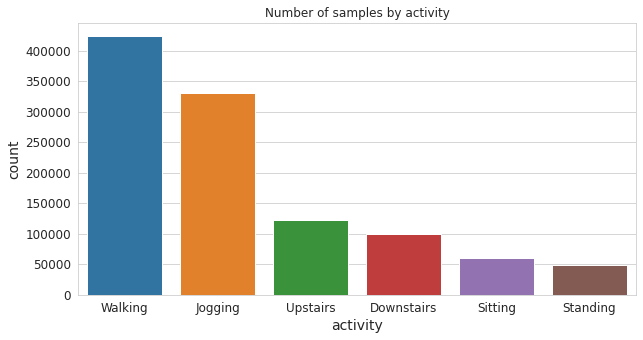

In [16]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.countplot(x ="activity", data=df)
plt.title("Number of samples by activity")
plt.show()

Plot how the users are contributing to each activity. This will help to decide how to split the data into training and testing sets

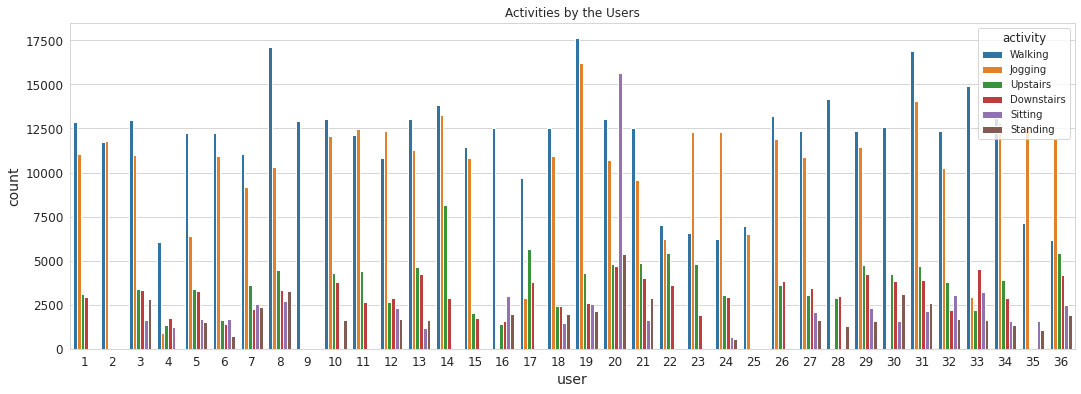

In [17]:
plt.figure(figsize=(18, 6))
sns.countplot(x="user", hue="activity", data=df)
plt.title("Activities by the Users")
plt.show()

For a particular user, observe how the signal values in each of the x, y and z dimension varies with time.

Consider a subset of 400 samples for visualising the signal. This is equivalent to 20 secs of the activity (as the frequency of data collection was 20 Hz). 

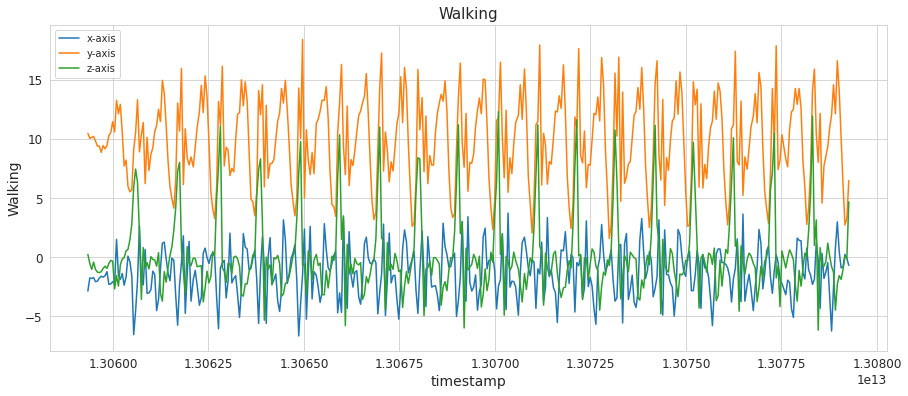

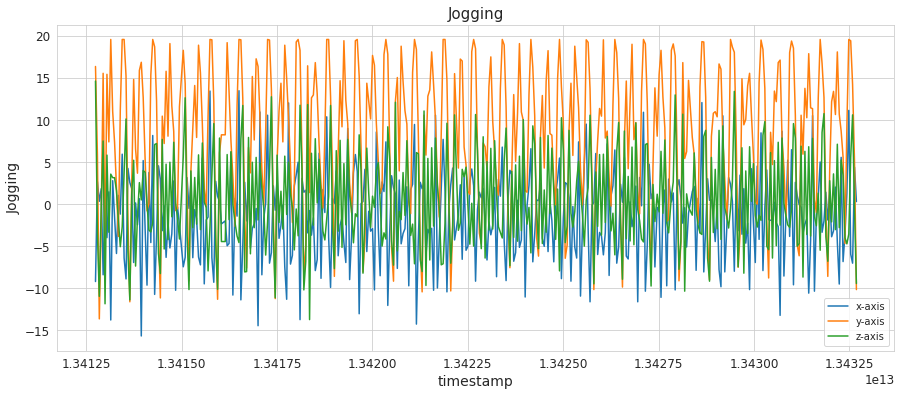

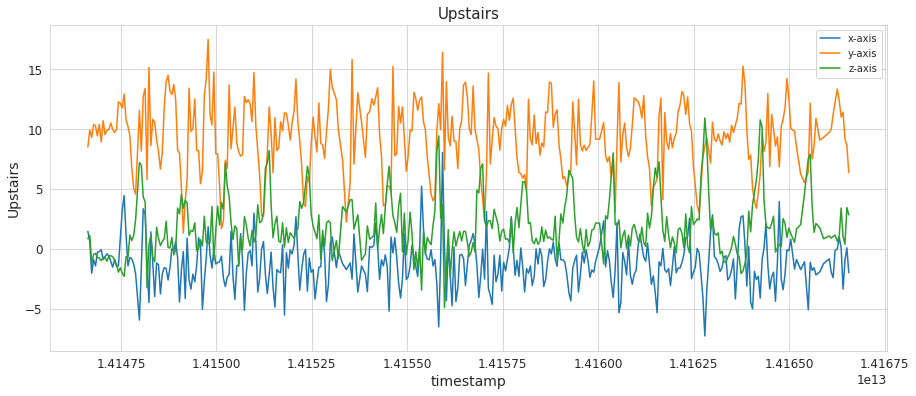

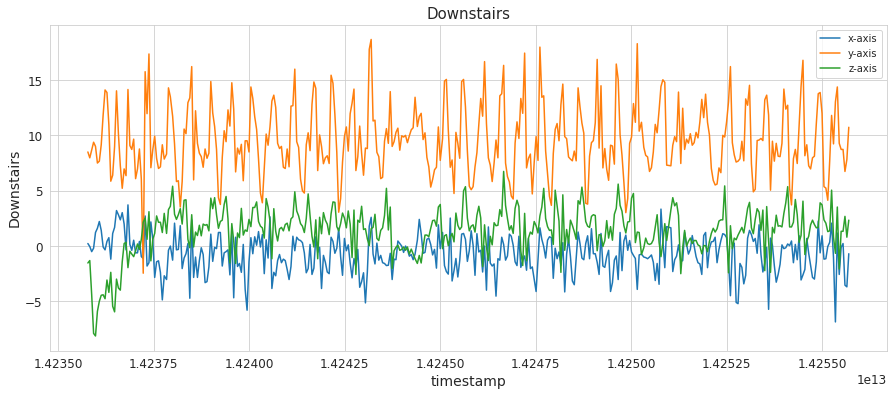

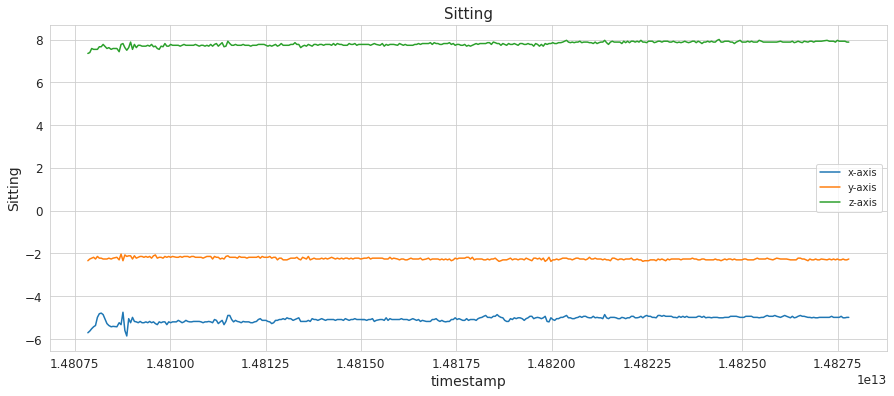

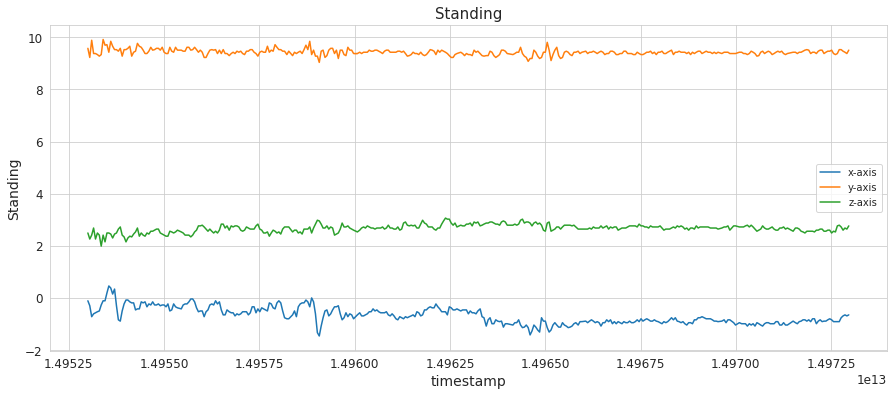

In [18]:
for i in list(pd.unique(df["activity"])):
    data_36 = df[(df["user"] == 36) & (df["activity"] == i)][:400]
    plt.figure(figsize = (15, 6))
    sns.lineplot(y="x-axis", x="timestamp", data=data_36)
    sns.lineplot(y="y-axis", x="timestamp", data=data_36)
    sns.lineplot(y="z-axis", x="timestamp", data=data_36)
    plt.legend(["x-axis", "y-axis", "z-axis"])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()

The signals show periodic behaviour for the activities like Walking, Jogging, Upstairs and Downstairs while there is less movement for stagnant activities like Sitting and Standing.

**Observe activity-wise distribution of the signal data along x, y and z axes to see if there is any obvious pattern based on the range and distribution of the values.**

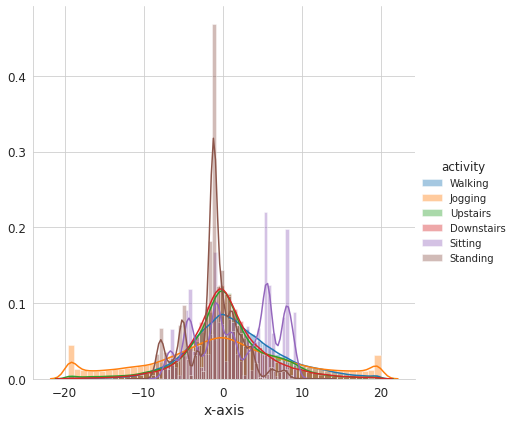

In [19]:
sns.FacetGrid(df, hue="activity", size=6).map(sns.distplot, "x-axis").add_legend()

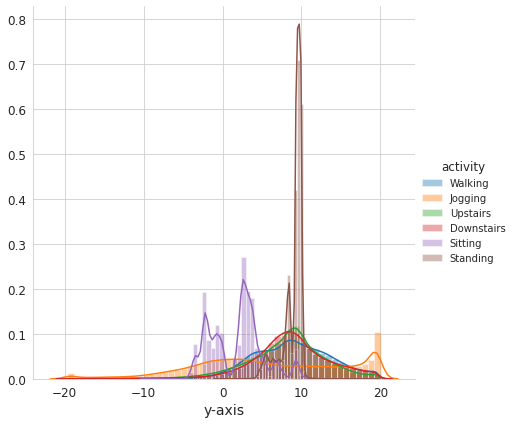

In [20]:
sns.FacetGrid(df, hue="activity", size=6).map(sns.distplot, "y-axis").add_legend()

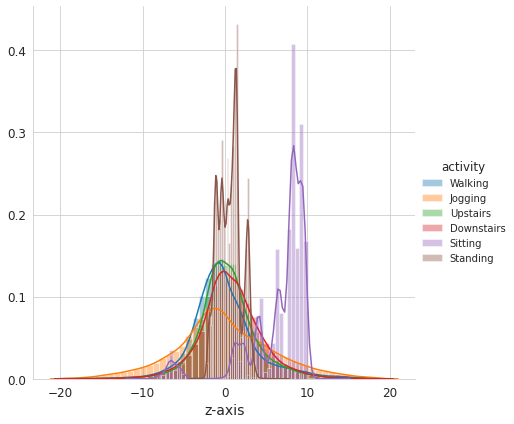

In [21]:
sns.FacetGrid(df, hue="activity", size=6).map(sns.distplot, "z-axis").add_legend()

It is observed that there is very high overlap in the data among activities like Upstairs, Downstairs, Walking, Jogging and Standing on all the axes. Sitting somewhat appears to have distinctive values along y-axis and z-axis.

## Data Transformation

**Transform the raw time-series data using ‘windowing’ technique.**

- sampling frequency: 20Hz
- divide the data into windows of 5 seconds: `20Hz * 5 secs = 100 samples`
- generate new features by aggregating these 100 raw samples contained within each of these 5 seconds' segments
- overlap: 50%. This ensures that every subsequent row in the transformed dataset has some information from the data of the previous window as well.

5 seconds window size is chosen based on relevant literature and this could be the optimal window-size that can be considered for capturing the repetitive motions involved in most of the six activities. Too less window-size may not capture the motion correctly, while too large window-size results in less datapoints in the transformed dataset for training.

![Windowing technique preview](images_notebooks/rolling_window_feature_engineering.png)

**Split the data into train and test sets**

This is just like doing 75–25 dataset split

In [22]:
# train data -> Users upto User ID = 27 (i.e. 27 users)
df_train = df[df["user"] <= 27] 

# test data -> Users from User ID = 28 to 36 (i.e. 9 users)
df_test = df[df["user"] > 27]

In [23]:
df_train.shape

(804358, 6)

In [24]:
df_test.shape

(281002, 6)

**Create overlapping windows of size 100 samples per window with 50% overlap**

In [25]:
def create_overlapping_windows(df, window_size, overlap):
    x_list = []
    y_list = []
    z_list = []
    labels = []

    # creating overlaping windows of size window-size 100
    for i in range(0, df.shape[0] - window_size, overlap):
        xs = df["x-axis"].values[i: i + 100]
        ys = df["y-axis"].values[i: i + 100]
        zs = df["z-axis"].values[i: i + 100]
        label = stats.mode(df["activity"][i: i + 100])[0][0]

        x_list.append(xs)
        y_list.append(ys)
        z_list.append(zs)
        labels.append(label)
    
    return {
        "x_list": x_list,
        "y_list": y_list,
        "z_list": z_list,
        "labels": labels
    }

In [26]:
op_windows_train = create_overlapping_windows(df=df_train, window_size=100, overlap=50)

In [27]:
op_windows_test = create_overlapping_windows(df=df_test, window_size=100, overlap=50)

In [28]:
print("Train x-axis list length:", len(op_windows_train["x_list"]))
print("Train y-axis list length:", len(op_windows_train["y_list"]))
print("Train z-axis list length:", len(op_windows_train["z_list"]))
print("Train labels list length:", len(op_windows_train["labels"]))
print()
print("Test x-axis list length:", len(op_windows_test["x_list"]))
print("Test y-axis list length:", len(op_windows_test["y_list"]))
print("Test z-axis list length:", len(op_windows_test["z_list"]))
print("Test labels list length:", len(op_windows_test["labels"]))


print("instance shape:", op_windows_train["x_list"][0].shape)

Train x-axis list length: 16086
Train y-axis list length: 16086
Train z-axis list length: 16086
Train labels list length: 16086

Test x-axis list length: 5619
Test y-axis list length: 5619
Test z-axis list length: 5619
Test labels list length: 5619
instance shape: (100,)


Each of these windows consists of 100 observations. Thus, the total instances for transformation are: 

    int(804358/50) -1 = 16086
    int(281002/50) - 1 = 5619

In [29]:
int(804358/50) - 1

16086

In [30]:
int(281002/50) - 1

5619

## Feature Engineering 01 - Statistical Features

Generate Statistical features:
1. mean
2. standard deviation
3. average absolute deviation
4. minimum value
5. maximum value
6. difference of maximum and minimum values
7. median
8. median absolute deviation
9. interquartile range
10. negative values count
11. positive values count
12. number of values above mean
13. number of peaks
14. skewness
15. kurtosis
16. energy
17. average resultant acceleration
18. signal magnitude area

Most of these features are self-explanatory.
- Energy of a signal in every axis is computed by taking the mean of sum of squares of the values in a window in that particular axis.
- Average resultant acceleration over the window is computed by taking average of the square roots of the values in the three axis squared and added together.
- Signal magnitude area is defined as the sum of absolute values of the three axis averaged over a window.

In [31]:
def feature_engineering_statistical(df, x_list, y_list, z_list):
    # mean
    df["x_mean"] = pd.Series(x_list).apply(lambda x: x.mean())
    df["y_mean"] = pd.Series(y_list).apply(lambda x: x.mean())
    df["z_mean"] = pd.Series(z_list).apply(lambda x: x.mean())

    # std dev
    df["x_std"] = pd.Series(x_list).apply(lambda x: x.std())
    df["y_std"] = pd.Series(y_list).apply(lambda x: x.std())
    df["z_std"] = pd.Series(z_list).apply(lambda x: x.std())

    # avg absolute diff
    df["x_aad"] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    df["y_aad"] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    df["z_aad"] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # min
    df["x_min"] = pd.Series(x_list).apply(lambda x: x.min())
    df["y_min"] = pd.Series(y_list).apply(lambda x: x.min())
    df["z_min"] = pd.Series(z_list).apply(lambda x: x.min())

    # max
    df["x_max"] = pd.Series(x_list).apply(lambda x: x.max())
    df["y_max"] = pd.Series(y_list).apply(lambda x: x.max())
    df["z_max"] = pd.Series(z_list).apply(lambda x: x.max())

    # max-min diff
    df["x_maxmin_diff"] = df["x_max"] - df["x_min"]
    df["y_maxmin_diff"] = df["y_max"] - df["y_min"]
    df["z_maxmin_diff"] = df["z_max"] - df["z_min"]

    # median
    df["x_median"] = pd.Series(x_list).apply(lambda x: np.median(x))
    df["y_median"] = pd.Series(y_list).apply(lambda x: np.median(x))
    df["z_median"] = pd.Series(z_list).apply(lambda x: np.median(x))

    # median abs dev 
    df["x_mad"] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    df["y_mad"] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    df["z_mad"] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # interquartile range
    df["x_IQR"] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    df["y_IQR"] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    df["z_IQR"] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # negtive count
    df["x_neg_count"] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
    df["y_neg_count"] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
    df["z_neg_count"] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

    # positive count
    df["x_pos_count"] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
    df["y_pos_count"] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
    df["z_pos_count"] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

    # values above mean
    df["x_above_mean"] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
    df["y_above_mean"] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
    df["z_above_mean"] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

    # number of peaks
    df["x_peak_count"] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
    df["y_peak_count"] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
    df["z_peak_count"] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

    # skewness
    df["x_skewness"] = pd.Series(x_list).apply(lambda x: stats.skew(x))
    df["y_skewness"] = pd.Series(y_list).apply(lambda x: stats.skew(x))
    df["z_skewness"] = pd.Series(z_list).apply(lambda x: stats.skew(x))

    # kurtosis
    df["x_kurtosis"] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
    df["y_kurtosis"] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
    df["z_kurtosis"] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

    # energy
    df["x_energy"] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
    df["y_energy"] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
    df["z_energy"] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

    # avg resultant
    df["avg_result_accl"] = [i.mean() for i in ((pd.Series(x_list)**2 \
                                                      + pd.Series(y_list)**2 \
                                                      + pd.Series(z_list)**2)**0.5)]

    # signal magnitude area
    df["sma"] = pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) \
                        + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                        + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))
    
    return df

In [32]:
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()
X_test = pd.DataFrame()

In [33]:
X_train = feature_engineering_statistical(df=X_train, 
                                          x_list=op_windows_train["x_list"], 
                                          y_list=op_windows_train["y_list"], 
                                          z_list=op_windows_train["z_list"])

In [34]:
X_train.head()

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_aad,y_aad,z_aad,x_min,...,y_skewness,z_skewness,x_kurtosis,y_kurtosis,z_kurtosis,x_energy,y_energy,z_energy,avg_result_accl,sma
0,3.6538,9.8101,-0.4788,5.508084,3.914714,3.201477,4.200456,3.173296,2.261984,-7.35,...,0.197839,1.077692,0.568973,-0.477694,1.882868,43.689240,111.563045,10.478702,11.927003,17.2871
1,3.8267,10.0261,-0.6779,5.543900,4.265195,3.200549,4.245502,3.438856,2.196162,-9.58,...,0.262148,0.908815,0.531894,-0.541396,2.706873,45.378457,118.714567,10.703061,12.231087,17.6551
2,3.8955,10.0714,-0.6730,5.942122,4.408135,3.365199,4.611740,3.497088,2.345800,-9.58,...,0.174965,0.854956,0.220855,-0.651948,2.468253,50.483739,120.864748,11.777494,12.494901,18.0813
3,4.0975,10.0045,-0.4714,5.787474,4.372943,3.437675,4.400350,3.444650,2.444004,-8.24,...,0.142432,0.933749,0.298709,-0.490570,2.019402,50.284367,119.212647,12.039824,12.483265,18.1690
4,3.8653,9.9209,-0.5538,5.843144,4.713848,3.454630,4.424276,3.842882,2.513868,-8.96,...,0.168218,0.594484,0.362344,-0.704194,1.367409,49.082875,120.644623,12.241162,12.393202,18.1092


In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16086 entries, 0 to 16085
Data columns (total 50 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   x_mean           16086 non-null  float64
 1   y_mean           16086 non-null  float64
 2   z_mean           16086 non-null  float64
 3   x_std            16086 non-null  float64
 4   y_std            16086 non-null  float64
 5   z_std            16086 non-null  float64
 6   x_aad            16086 non-null  float64
 7   y_aad            16086 non-null  float64
 8   z_aad            16086 non-null  float64
 9   x_min            16086 non-null  float64
 10  y_min            16086 non-null  float64
 11  z_min            16086 non-null  float64
 12  x_max            16086 non-null  float64
 13  y_max            16086 non-null  float64
 14  z_max            16086 non-null  float64
 15  x_maxmin_diff    16086 non-null  float64
 16  y_maxmin_diff    16086 non-null  float64
 17  z_maxmin_dif

In [36]:
X_test = feature_engineering_statistical(df=X_test, 
                                         x_list=op_windows_test["x_list"], 
                                         y_list=op_windows_test["y_list"], 
                                         z_list=op_windows_test["z_list"])

In [37]:
X_test.head()

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_aad,y_aad,z_aad,x_min,...,y_skewness,z_skewness,x_kurtosis,y_kurtosis,z_kurtosis,x_energy,y_energy,z_energy,avg_result_accl,sma
0,0.2498,9.3531,2.923335,2.017761,3.286944,2.197032,1.614216,2.377610,1.756930,-5.41,...,0.673697,-0.069640,0.068771,0.759811,0.583183,4.133760,98.284481,13.372840,10.332890,14.132892
1,0.7676,9.6369,2.594540,1.945526,3.022883,2.282750,1.510688,2.300390,1.780427,-4.71,...,0.575176,0.491176,0.169127,0.552430,0.069141,4.374280,102.007661,11.942587,10.498274,14.117145
2,0.6983,9.8614,2.441175,2.466917,4.277981,2.533826,1.960270,3.396852,1.951428,-7.04,...,0.594889,0.464006,0.565550,-0.302692,0.393846,6.573303,115.548334,12.379609,10.854949,14.735045
3,0.4744,9.9016,2.328807,2.840880,4.999662,2.779943,2.153472,4.065760,2.071862,-8.81,...,0.206242,0.915207,0.918362,-0.760667,0.624313,8.295654,123.038300,13.151427,10.953875,14.824160
4,0.8599,9.5896,2.051905,2.532861,4.111530,2.887250,1.880502,3.212784,1.998909,-8.81,...,-0.025791,1.385770,2.108183,-0.253716,1.671524,7.154811,108.865106,12.546527,10.481538,14.089713


In [38]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 50 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   x_mean           5619 non-null   float64
 1   y_mean           5619 non-null   float64
 2   z_mean           5619 non-null   float64
 3   x_std            5619 non-null   float64
 4   y_std            5619 non-null   float64
 5   z_std            5619 non-null   float64
 6   x_aad            5619 non-null   float64
 7   y_aad            5619 non-null   float64
 8   z_aad            5619 non-null   float64
 9   x_min            5619 non-null   float64
 10  y_min            5619 non-null   float64
 11  z_min            5619 non-null   float64
 12  x_max            5619 non-null   float64
 13  y_max            5619 non-null   float64
 14  z_max            5619 non-null   float64
 15  x_maxmin_diff    5619 non-null   float64
 16  y_maxmin_diff    5619 non-null   float64
 17  z_maxmin_diff 

## Feature Engineering 02 - Fast-Fourier transform (FFT)

Features generated from the transformation of the raw signal from time domain to the frequency domain.

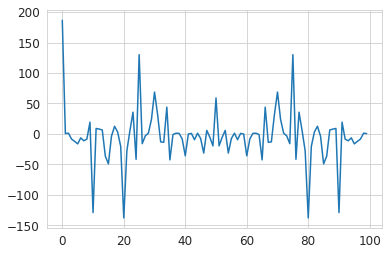

In [39]:
pd.Series(np.fft.fft(pd.Series(op_windows_train["x_list"])[42])).plot()
plt.show()

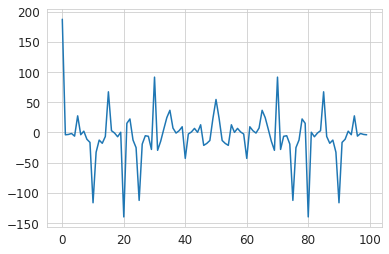

In [40]:
pd.Series(np.fft.fft(pd.Series(op_windows_train["x_list"])[43])).plot()
plt.show()

Some observations:
- The first value is unusually high. This is called as ‘DC component’ or ‘DC offset’ in electrical terminology.
- The wave signal is symmetric around the centre.

**Consider also for analysis only the *first half* of the signal. This will ensure that unbiased statistical features from it are obtained.**

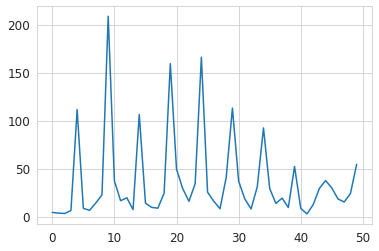

In [41]:
pd.Series(np.abs(np.fft.fft(pd.Series(op_windows_train["x_list"])[43]))[1:51]).plot()
plt.show()

**Convert the signals from time domain to frequency domain using FFT**

In [42]:
def convert_signals_to_freq_domain(x_list, y_list, z_list):
    x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
    y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
    z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
    
    return x_list_fft, y_list_fft, z_list_fft

In [43]:
x_list_fft_train, y_list_fft_train, z_list_fft_train =  convert_signals_to_freq_domain(op_windows_train["x_list"], 
                                                                                       op_windows_train["y_list"], 
                                                                                       op_windows_train["z_list"])

In [44]:
type(x_list_fft_train)

pandas.core.series.Series

In [45]:
x_list_fft_test, y_list_fft_test, z_list_fft_test =  convert_signals_to_freq_domain(op_windows_test["x_list"], 
                                                                                    op_windows_test["y_list"], 
                                                                                    op_windows_test["z_list"])

**Statistical Features applied in raw x, y and z axis at the frequency domain**

In [46]:
def feature_engineering_fft(df, x_list_fft, y_list_fft, z_list_fft):
    # FFT mean
    df['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
    df['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
    df['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

    # FFT std dev
    df['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
    df['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
    df['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

    # FFT avg absolute diff
    df['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    df['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    df['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # FFT min
    df['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
    df['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
    df['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

    # FFT max
    df['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
    df['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
    df['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

    # FFT max-min diff
    df['x_maxmin_diff_fft'] = df['x_max_fft'] - df['x_min_fft']
    df['y_maxmin_diff_fft'] = df['y_max_fft'] - df['y_min_fft']
    df['z_maxmin_diff_fft'] = df['z_max_fft'] - df['z_min_fft']

    # FFT median
    df['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
    df['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
    df['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

    # FFT median abs dev 
    df['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    df['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    df['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # FFT Interquartile range
    df['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    df['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    df['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # FFT values above mean
    df['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
    df['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
    df['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

    # FFT number of peaks
    df['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
    df['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
    df['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

    # FFT skewness
    df['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
    df['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
    df['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

    # FFT kurtosis
    df['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
    df['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
    df['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

    # FFT energy
    df['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
    df['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
    df['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

    # FFT avg resultant
    df['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 \
                                                          + pd.Series(y_list_fft)**2 \
                                                          + pd.Series(z_list_fft)**2)**0.5)]

    # FFT Signal magnitude area
    df['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                        + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                        + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))
    
    return df

In [47]:
X_train = feature_engineering_fft(X_train, x_list_fft_train, y_list_fft_train, z_list_fft_train)
X_test = feature_engineering_fft(X_test, x_list_fft_test, y_list_fft_test, z_list_fft_test)

In [48]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16086 entries, 0 to 16085
Data columns (total 94 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   x_mean               16086 non-null  float64
 1   y_mean               16086 non-null  float64
 2   z_mean               16086 non-null  float64
 3   x_std                16086 non-null  float64
 4   y_std                16086 non-null  float64
 5   z_std                16086 non-null  float64
 6   x_aad                16086 non-null  float64
 7   y_aad                16086 non-null  float64
 8   z_aad                16086 non-null  float64
 9   x_min                16086 non-null  float64
 10  y_min                16086 non-null  float64
 11  z_min                16086 non-null  float64
 12  x_max                16086 non-null  float64
 13  y_max                16086 non-null  float64
 14  z_max                16086 non-null  float64
 15  x_maxmin_diff        16086 non-null 

The outcome from the both Feature Engineering parts is a list of 94 features!!

In [49]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 94 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   x_mean               5619 non-null   float64
 1   y_mean               5619 non-null   float64
 2   z_mean               5619 non-null   float64
 3   x_std                5619 non-null   float64
 4   y_std                5619 non-null   float64
 5   z_std                5619 non-null   float64
 6   x_aad                5619 non-null   float64
 7   y_aad                5619 non-null   float64
 8   z_aad                5619 non-null   float64
 9   x_min                5619 non-null   float64
 10  y_min                5619 non-null   float64
 11  z_min                5619 non-null   float64
 12  x_max                5619 non-null   float64
 13  y_max                5619 non-null   float64
 14  z_max                5619 non-null   float64
 15  x_maxmin_diff        5619 non-null   f

## Train and Evaluate a Supervised Model for Activity Recognition

Transform labels from lists to NumPy arrays 

In [50]:
y_train = np.array(op_windows_train["labels"])
y_test = np.array(op_windows_test["labels"])

Scale the data

In [51]:
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Initiate the ML model

In [52]:
lr = LogisticRegression(random_state=21)

Train

In [53]:
lr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=21)

Predict

In [54]:
y_pred = lr.predict(X_test_scaled)

**Evaluate**

In [55]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8457020822210358


In [56]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.69      0.77      0.73       576
     Jogging       0.82      0.94      0.88      1522
     Sitting       0.85      1.00      0.92       361
    Standing       0.96      0.80      0.88       323
    Upstairs       0.71      0.65      0.68       640
     Walking       0.95      0.84      0.89      2197

    accuracy                           0.85      5619
   macro avg       0.83      0.83      0.83      5619
weighted avg       0.85      0.85      0.85      5619



In [57]:
labels_list = np.unique(y_train)
labels_list

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype='<U10')

In [58]:
cm = confusion_matrix(y_test, y_pred)

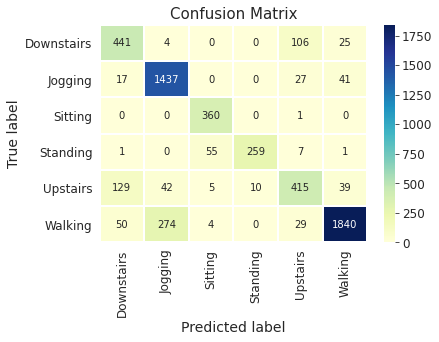

In [59]:
sns.heatmap(cm, xticklabels=labels_list, yticklabels=labels_list, 
            annot=True, linewidths=0.1, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix", fontsize = 15)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

## References

- https://towardsdatascience.com/feature-engineering-on-time-series-data-transforming-signal-data-of-a-smartphone-accelerometer-for-72cbe34b8a60
- https://www.cis.fordham.edu/wisdm/dataset.php
- https://www.cis.fordham.edu/wisdm/publications.php